In [68]:
import json
import os
import glob
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler
from sklearn import manifold
from sklearn.metrics import r2_score
import scipy as sp
import scipy.cluster.hierarchy as hc
from scipy.spatial import distance
from nilearn.input_data import NiftiLabelsMasker
from nilearn import plotting
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)}, font_scale=1.8)

# Preliminaries

In [69]:
# Define params
firstlevel_label = 'first_level_bySession'
analysis_name = 'analysis-3'
parcels = 1000
model_names = ['RidgeCV']
parc_label = 'schaefer_2018'
space_label = 'MNI152NLin2009cAsym'

# Define paths
proj_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
resources_dir = os.path.join(proj_dir, 'resources')
firstlevel_dir = os.path.join(proj_dir, 'Y_data', firstlevel_label)
results_dir = os.path.join(proj_dir, 'model_outputs', firstlevel_label, analysis_name)
features_dir = os.path.join(proj_dir, 'X_features')

# Define subs
subs = [2, 3, 4, 6, 8, 9, 10, 12, 14, 15, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31]
excluded_subs = [29]
subs = ['sub-%02d' % s for s in subs if s not in excluded_subs] 
num_subs = len(subs)

# Load feature matrix
feature_set = 'X_all'
X = pd.read_csv(os.path.join(features_dir, f'byTask/{feature_set}.csv'), index_col=0)
task_order = X.index.tolist()
features = X.columns.tolist()

# Check task order
X_bySession = pd.read_csv(os.path.join(features_dir, f'byTask_bySession/{feature_set}.csv'), index_col=0)
ts = []
for t in X_bySession['task_name'].tolist():
    if t not in ts:
        ts.append(t)
assert(ts==task_order)

# Load task2task dict (for more readable naming format), and get task order
with open(os.path.join(resources_dir, 'dicts/task2task.json'), 'rb') as f:
    task2task = json.load(f)
task2task_inv = {v: k for k, v in task2task.items()}

# Performance metrics

## Load model results

In [70]:
def get_avg_metric(res_df, metric='corr_vals', new_col='corr_mean'):
    ## Compute an average across splits and tasks, for each subject (and for null models also across iterations)

    res_df[new_col] = np.nan
    for row_idx in range(res_df.shape[0]):
        metric_all_iterations = res_df[metric].iloc[row_idx]
        avg_vals = []
        for iteration in metric_all_iterations:
            iter_vals = []
            for split in iteration:
                for task in split:
                    iter_vals.extend(task)
            # Average for each iteration
            avg_vals.append(np.mean(iter_vals))
        # Average across iterations (for non-null models, the number of iterations is 1) 
        res_df[new_col].iloc[row_idx] = np.mean(avg_vals)
    return res_df

In [71]:
## Aggregate results into one df

res_df = None
for model_name in model_names:
    model_output_dir = os.path.join(results_dir, model_name)
    
    # Get list of dicts from the pkl files
    dict_list = []
    pkls = sorted(glob.glob(os.path.join(model_output_dir, '*')))
    for fname in pkls:
        with open(fname, 'rb') as f:
            d = pickle.load(f)
        # if null, make explicit in feature set label 
        num_parcels = list(d.keys())[0]
        feature_set = list(d[num_parcels].keys())[0]
        model_name = list(d[num_parcels][feature_set].keys())[0]
        sub = list(d[num_parcels][feature_set][model_name].keys())[0]
        d[num_parcels][feature_set][model_name][sub]['seed'] = 0
        if 'shuffle' in fname:
            feature_set_new = fname.split('_')[-3]
            seed = fname.split('_')[-2].split('-')[-1]
            d[num_parcels][feature_set_new] = d[num_parcels].pop(feature_set)
            d[num_parcels][feature_set_new][model_name][sub]['seed'] = seed
        dict_list.append(d)

    # Aggregate dicts into a df
    for d in dict_list:
        num_parcels = list(d.keys())[0]
        feature_set = list(d[num_parcels].keys())[0]
        model_name = list(d[num_parcels][feature_set].keys())[0]
        sub = list(d[num_parcels][feature_set][model_name].keys())[0]
        sub_dict = d[num_parcels][feature_set][model_name][sub]
        metrics = list(sub_dict.keys())
        metrics = [i for i in metrics if i != 'preds']            
        
        if res_df is None:
            cols = ['parcels', 'feature_set', 'model_name', 'sub']
            cols.extend(metrics)
            res_df = pd.DataFrame(columns=cols)

        row = [num_parcels, feature_set, model_name, sub]
        for m in metrics:
            if m in ['acc1', 'acc2']:
                item = np.mean(sub_dict[m])
            else:
                item = sub_dict[m]
            if m not in ['preds']:
                row.append(item)
        res_df = res_df.append(pd.Series(row, index=res_df.columns), ignore_index=True)

res_df = get_avg_metric(res_df, metric='corr_vals', new_col='corr_mean')
res_df = get_avg_metric(res_df, metric='r2_vals', new_col='r2_mean')

/Users/walters/opt/anaconda3/envs/multitask_env/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [72]:
# Aggregate null models
null_df = pd.DataFrame(columns=res_df.columns)
null_labels = [i for i in res_df['feature_set'].unique().tolist() if 'shuffle' in i]
measures = ['acc1', 'corr_mean', 'r2_mean']

for null in null_labels:
    for sub in subs:
        sub_null_df = res_df[(res_df['feature_set']==null) & (res_df['sub']==sub)]
        sub_df = pd.DataFrame(columns=res_df.columns)
        sub_df.loc[sub_df.shape[0]] = [0 for i in range(len(res_df.columns))]   
        sub_df.iloc[0]['sub'] = sub
        sub_df.iloc[0]['feature_set'] = null
        for m in measures:
            sub_df.iloc[0][m] = sub_null_df[m].mean()
        null_df = pd.concat([null_df, sub_df])

    res_df.drop(res_df[(res_df['feature_set']==null)].index, inplace=True)

for m in measures:
    null_df[m] = null_df[m].astype('float64')
null_df['feature_set'] = null_df['feature_set'].astype('string')
res_df = pd.concat([res_df, null_df])
res_df = res_df.reset_index(drop=True)

In [73]:
RidgeCV_df = res_df[res_df['model_name']=='RidgeCV']

## Plot metrics

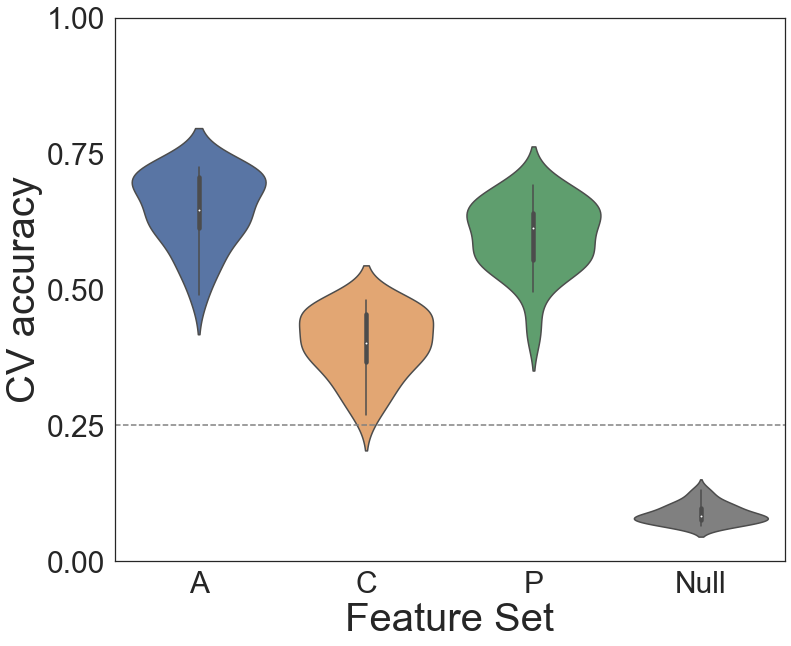

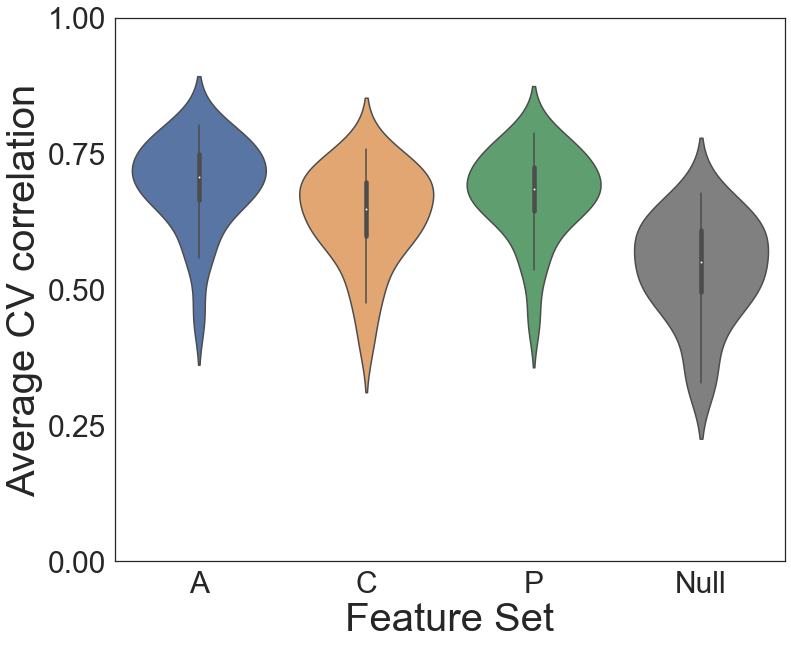

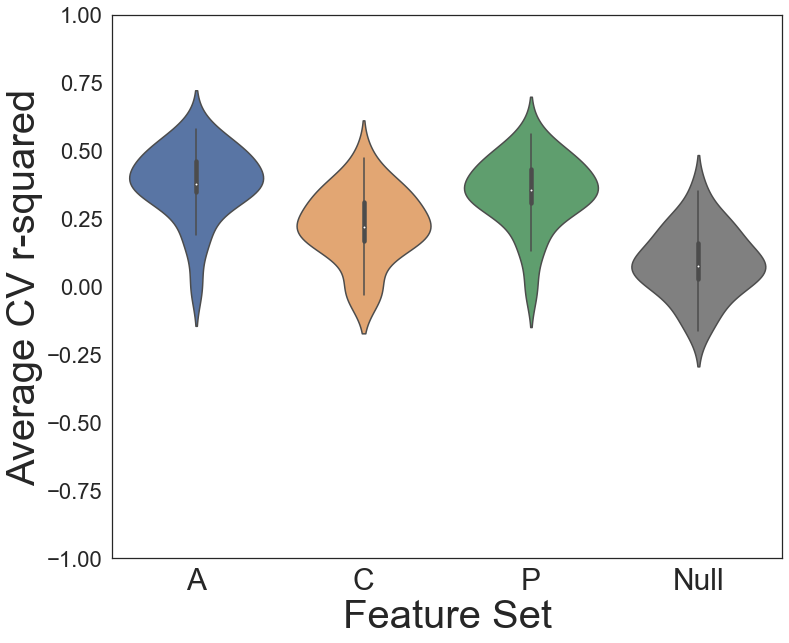

In [74]:
## Plot accuracy, correlation, and r-squared

sns.set(style='white', font_scale=2)

df = res_df
filetype = 'pdf'

fig_dir = 'figures/subject-specific-models'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

order = ['all', 'cognitive', 'perceptualmotor', 'all-shuffle-tasks']
xticklabels = ['A', 'C', 'P', 'Null']
palette = ['b','sandybrown','g','grey']

labelsize = 40
ticksize = 30

# Two-way classification accuracy
metric = 'acc1'
plt.figure(figsize=(12,10))
ax = sns.violinplot(x='feature_set', y=metric, data=df, order=order, scale='width', palette=palette)
plt.xlabel('Feature Set', fontsize=labelsize)
plt.ylabel('CV accuracy', fontsize=labelsize);
ax.set_xticklabels(xticklabels, fontsize=ticksize)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], size=ticksize)
ax.axhline(0.25, ls='--', color='grey')
plt.savefig(os.path.join(fig_dir, 'classification_accuracy.%s' % filetype))


# Map-wise correlations (average across all 1892 predictions, per subject)
metric = 'corr_mean'
plt.figure(figsize=(12,10))
ax = sns.violinplot(x='feature_set', y=metric, data=df, order=order, scale='width', palette=palette, widths=10)
plt.xlabel('Feature Set', fontsize=labelsize)
plt.ylabel('Average CV correlation', fontsize=labelsize);
ax.set_xticklabels(xticklabels, fontsize=ticksize)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], size=ticksize)
plt.savefig(os.path.join(fig_dir, 'avg_map-correlations.%s' % filetype))


# Map-wise r2 (average across all 1892 predictions, per subject)
metric = 'r2_mean'
plt.figure(figsize=(12,10))
ax = sns.violinplot(x='feature_set', y=metric, data=df, order=order, scale='width', palette=palette, widths=10)
plt.xlabel('Feature Set', fontsize=labelsize)
plt.ylabel('Average CV r-squared', fontsize=labelsize);
ax.set_xticklabels(xticklabels, fontsize=ticksize)
#plt.yticks([0, 0.25, 0.5, 0.75, 1.0], size=ticksize)
plt.savefig(os.path.join(fig_dir, 'avg_map-correlations.%s' % filetype))
plt.ylim(-1, 1);

## Descriptive stats and tests

In [75]:
# Descriptive stats for each feature set

perf_avgs = df.groupby('feature_set').mean()
perf_stds = df.groupby('feature_set').std()

for metric in perf_avgs.columns:
    print(metric)
    for feature_set in perf_avgs.index:
        print(f'{feature_set} (M = {perf_avgs[metric][feature_set]:.2f}, SD = {perf_stds[metric][feature_set]:.2f})')
    print()

acc1
all (M = 0.65, SD = 0.07)
all-shuffle-features (M = 0.11, SD = 0.02)
all-shuffle-tasks (M = 0.09, SD = 0.02)
cognitive (M = 0.40, SD = 0.06)
perceptualmotor (M = 0.60, SD = 0.07)

corr_mean
all (M = 0.69, SD = 0.08)
all-shuffle-features (M = 0.52, SD = 0.09)
all-shuffle-tasks (M = 0.54, SD = 0.10)
cognitive (M = 0.63, SD = 0.09)
perceptualmotor (M = 0.67, SD = 0.08)

r2_mean
all (M = 0.38, SD = 0.13)
all-shuffle-features (M = -0.07, SD = 0.15)
all-shuffle-tasks (M = 0.09, SD = 0.12)
cognitive (M = 0.22, SD = 0.13)
perceptualmotor (M = 0.35, SD = 0.13)



In [76]:
# Tests for differences in accuracy between feature sets

df = RidgeCV_df

# One-way repeated measures ANOVA
display(pg.rm_anova(dv='acc1', within='feature_set', subject='sub', data=df, detailed=True))

# Bonferroni-corrected post-hoc tests 
display(pg.pairwise_ttests(dv='acc1', within='feature_set', subject='sub', padjust='bonf', data=df))

/Users/walters/opt/anaconda3/envs/multitask_env/lib/python3.7/site-packages/pingouin/distribution.py:972: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d)**d


,Source,SS,DF,MS,F,p-unc,np2,eps
0,feature_set,0.792315,2,0.396158,750.663334,9.942882e-35,0.971527,0.804368
1,Error,0.023221,44,0.000528,NaN,NaN,NaN,NaN


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,feature_set,all,cognitive,True,True,32.692781,22.0,two-sided,3.812608e-20,1.143782e-19,bonf,8.238e+16,3.821566
1,feature_set,all,perceptualmotor,True,True,10.500131,22.0,two-sided,4.931233e-10,1.479370e-09,bonf,2.137e+07,0.745753
2,feature_set,cognitive,perceptualmotor,True,True,-26.260126,22.0,two-sided,4.208546e-18,1.262564e-17,bonf,9.342e+14,-3.064288


In [77]:
# Tests for differences in accuracy between feature sets

df = RidgeCV_df

# One-way repeated measures ANOVA
display(pg.rm_anova(dv='corr_mean', within='feature_set', subject='sub', data=df, detailed=True))

# Bonferroni-corrected post-hoc tests 
display(pg.pairwise_ttests(dv='corr_mean', within='feature_set', subject='sub', padjust='bonf', data=df))

/Users/walters/opt/anaconda3/envs/multitask_env/lib/python3.7/site-packages/pingouin/distribution.py:972: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d)**d


,Source,SS,DF,MS,F,p-unc,np2,eps
0,feature_set,0.041291,2,0.020645,336.859133,2.113347e-27,0.938695,0.67515
1,Error,0.002697,44,0.000061,NaN,NaN,NaN,NaN


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,feature_set,all,cognitive,True,True,22.780711,22.0,two-sided,8.627255e-17,2.588177e-16,bonf,5.28e+13,0.669711
1,feature_set,all,perceptualmotor,True,True,14.648107,22.0,two-sided,7.912357e-13,2.373707e-12,bonf,9.196e+09,0.226417
2,feature_set,cognitive,perceptualmotor,True,True,-14.348120,22.0,two-sided,1.196875e-12,3.590626e-12,bonf,6.218e+09,-0.458627


In [78]:
# Tests for differences in accuracy between feature sets

df = RidgeCV_df

# One-way repeated measures ANOVA
display(pg.rm_anova(dv='r2_mean', within='feature_set', subject='sub', data=df, detailed=True))

# Bonferroni-corrected post-hoc tests 
display(pg.pairwise_ttests(dv='r2_mean', within='feature_set', subject='sub', padjust='bonf', data=df))

,Source,SS,DF,MS,F,p-unc,np2,eps
0,feature_set,0.308143,2,0.154071,170.062085,1.984189e-21,0.885454,0.537131
1,Error,0.039863,44,0.000906,NaN,NaN,NaN,NaN


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,feature_set,all,cognitive,True,True,14.345767,22.0,two-sided,1.200802e-12,3.602405e-12,bonf,6.198e+09,1.155462
1,feature_set,all,perceptualmotor,True,True,13.177277,22.0,two-sided,6.457032e-12,1.937110e-11,bonf,1.265e+09,0.234939
2,feature_set,cognitive,perceptualmotor,True,True,-11.551963,22.0,two-sided,8.226435e-11,2.467930e-10,bonf,1.15e+08,-0.934674


## Accuracy as a function of feature set and type of cross-validation split

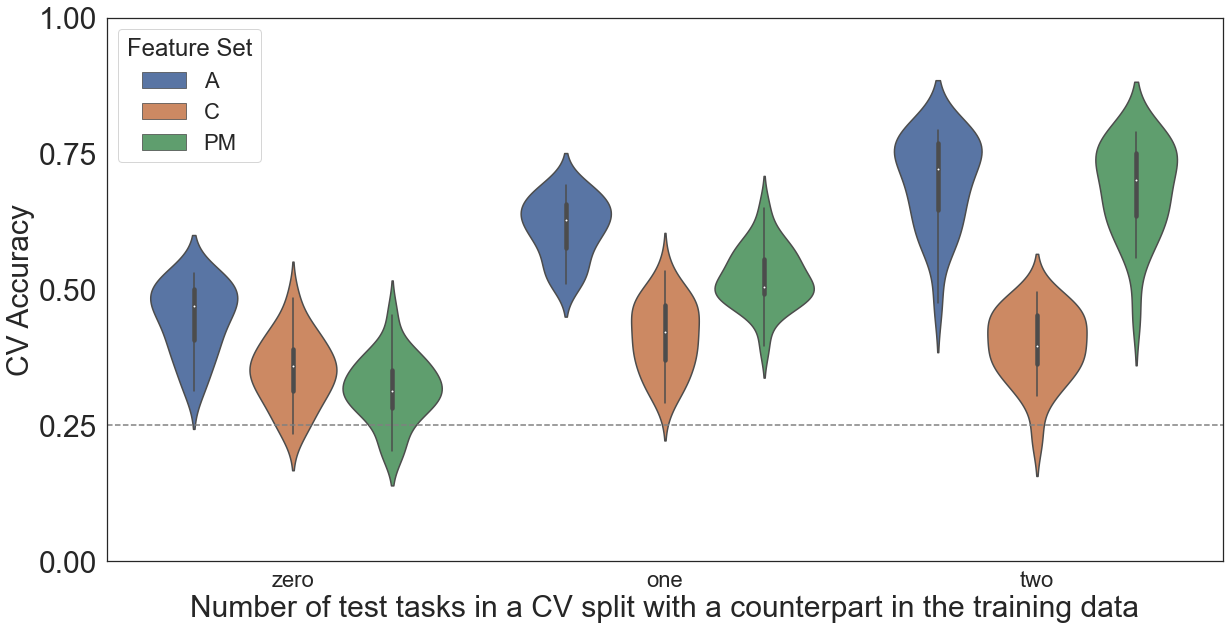

In [79]:
df = RidgeCV_df
test_indices = df.iloc[0]['testpairs'][0]
task_key_df = pd.read_csv(os.path.join(resources_dir, 'task_key.csv'))

all_pairs = []
pairs_0, pairs_1, pairs_2 = [], [], []
mask0, mask1, mask2 = [], [], []

for split in test_indices:
    task_a_idx = split.min()
    task_b_idx = split.max()
    task_a_name = task_order[task_a_idx]
    task_b_name = task_order[task_b_idx]
    pair = [task_key_df[task_key_df['condition']==task_a_name]['num_conds'].values[0],
            task_key_df[task_key_df['condition']==task_b_name]['num_conds'].values[0]]
    
    metatask_a = task_key_df[task_key_df['condition']==task_a_name]['task'].values[0]
    metatask_b = task_key_df[task_key_df['condition']==task_b_name]['task'].values[0]
    
    mask0.append(0)
    mask1.append(0)
    mask2.append(0)

    if (pair == [1, 1]) or (pair == [2, 2] and metatask_a==metatask_b):
        pairs_0.append(split)
        mask0[-1] = 1
    elif 1 in pair:
        pairs_1.append(split)
        mask1[-1] = 1
    else:
        pairs_2.append(split)
        mask2[-1] = 1
    all_pairs.append(sorted(pair))


def make_type_df(df, feature_set, feature_set_label, mask0, mask1, mask2):
    df_all = df[df['feature_set']==feature_set]
    type_rows = []
    for i, row in df_all.iterrows():
        acc_0 = np.dot(np.array(mask0), np.array(row['acc1_vals'][0]).T) / np.sum(mask0)
        acc_1 = np.dot(np.array(mask1), np.array(row['acc1_vals'][0]).T) / np.sum(mask1)
        acc_2 = np.dot(np.array(mask2), np.array(row['acc1_vals'][0]).T) / np.sum(mask2)
        type_rows.append([acc_0, acc_1, acc_2])
    type_df = pd.DataFrame(type_rows, columns=['zero', 'one', 'two'])
    type_df['sub'] = subs
    type_df = type_df.melt(var_name='type', value_name='acc', id_vars=['sub'])
    type_df['feature_set'] = feature_set_label
    
    return type_df
    

type_df_A = make_type_df(RidgeCV_df, 'all', 'A', mask0, mask1, mask2)
type_df_C = make_type_df(RidgeCV_df, 'cognitive', 'C', mask0, mask1, mask2)
type_df_PM = make_type_df(RidgeCV_df, 'perceptualmotor', 'PM', mask0, mask1, mask2)
type_df = pd.concat([type_df_A, type_df_C, type_df_PM])

plt.figure(figsize=(20, 10))
labelsize = 30
ax = sns.violinplot(x='type', y='acc', data=type_df, hue='feature_set')
ax.set_xlabel('Number of test tasks in a CV split with a counterpart in the training data', fontsize=labelsize);
ax.set_ylabel('CV Accuracy', fontsize=labelsize)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], size=labelsize)
plt.ylim(0, 1)
ax.axhline(0.25, ls='--', color='grey')
ax.legend(title='Feature Set');

## Average optimal regularization strength across subjects

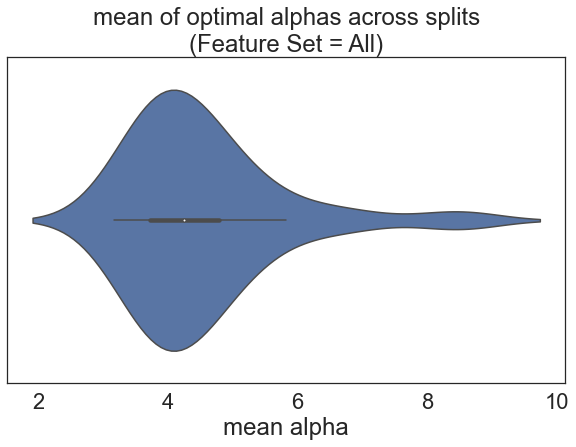

In [80]:
alpha_means = [np.mean(s[0]) for s in RidgeCV_df[RidgeCV_df['feature_set']=='all']['alphas'].values]
plt.figure();
ax = sns.violinplot(x=alpha_means);
plt.xlabel('mean alpha')
plt.title('mean of optimal alphas across splits\n(Feature Set = All)');

# Noise ceiling

## Get reliabilities 

In [81]:
# Define dirs, etc
session_a1_dir = os.path.join(firstlevel_dir, 'a1')
session_a2_dir = os.path.join(firstlevel_dir, 'a2')
session_b1_dir = os.path.join(firstlevel_dir, 'b1')
session_b2_dir = os.path.join(firstlevel_dir, 'b2')

session_dirs_a = [session_a1_dir, session_a2_dir]
session_dirs_b = [session_b1_dir, session_b2_dir]

sessions_a = ['a1', 'a2']
sessions_b = ['b1', 'b2']

subs_a = sorted([os.path.basename(i) for i in glob.glob(session_a1_dir + '/*')])
subs_b = sorted([os.path.basename(i) for i in glob.glob(session_b2_dir + '/*')])

tasks_a = sorted([os.path.basename(i)[7:-9] for i in glob.glob(f'{session_dirs_a[0]}/{sub}/parcellated/{parc_label}/{space_label}/{sub}*')])
tasks_b = sorted([os.path.basename(i)[7:-9] for i in glob.glob(f'{session_dirs_b[0]}/{sub}/parcellated/{parc_label}/{space_label}/{sub}*')])
tasks_a_renamed = [task2task[t] for t in tasks_a]
tasks_b_renamed = [task2task[t] for t in tasks_b]
num_tasks = len(sorted(list(set.union(set(tasks_a), set(tasks_b)))))

In [82]:
def between_session_corr(sessions, tasks, session_dirs, subs):
    task_corr_dict = {task:[] for task in tasks}
    for task in tasks:
        corrs = []
        for sub in subs:
            session_1 = np.load(glob.glob(f'{session_dirs[0]}/{sub}/parcellated/{parc_label}/{space_label}/{sub}_{task}_zmap.npy')[0])
            session_2 = np.load(glob.glob(f'{session_dirs[1]}/{sub}/parcellated/{parc_label}/{space_label}/{sub}_{task}_zmap.npy')[0])
            corrs.append(np.corrcoef(session_1, session_2)[0,1])
        task_corr_dict[task] = corrs
    return task_corr_dict

In [83]:
# Calculate reliability as the between-session correlations for each task and store in df
reliability_a = between_session_corr(sessions_a, tasks_a, session_dirs_a, subs_a)
reliability_b = between_session_corr(sessions_b, tasks_b, session_dirs_b, subs_b)
df_reliability_a = pd.DataFrame(reliability_a).rename(task2task, axis=1)
df_reliability_b = pd.DataFrame(reliability_b).rename(task2task, axis=1)

## Get model correlations

In [84]:
# Get model correlations
model_name = 'RidgeCV'
feature_set = 'all'

model_task_corrs = {i:[] for i in range(num_tasks)}
for sub in subs:
    sub_result = f'{model_output_dir}/{firstlevel_label}_{analysis_name}_{parcels}-parcels_{model_name}_{feature_set}_{sub}.pkl'
    with open(sub_result, 'rb') as f:
        res = pickle.load(f)

    corr_list = res[parcels][feature_set][model_name][sub]['corr_vals'][0]
    test_pairs = res[parcels][feature_set][model_name][sub]['testpairs'][0]

    task_corr_dict = {i:[] for i in range(num_tasks)}
    for test_pair, corrs in zip(test_pairs, corr_list):
        t0 = test_pair.min()
        t1 = test_pair.max()
        task_corr_dict[t0].extend(corrs[0])
        task_corr_dict[t1].extend(corrs[1])
    
    for task_idx in range(num_tasks):
        model_task_corrs[task_idx].append(np.mean(task_corr_dict[task_idx]))
        

## Aggregate model correlations and reliabilities 

In [85]:
all_session_corrs = []
all_model_corrs = []

all_session_corrs_dict = {}
for task_idx in range(len(task_order)):

    session_corrs = []
    corrs_a = []
    corrs_b = []
    
    task_name = task_order[task_idx]
    in_A = (task_name in tasks_a_renamed)
    in_B = (task_name in tasks_b_renamed)
    
    if in_A:
        corrs_a = df_reliability_a[task_name].tolist()
    if in_B:
        corrs_b = df_reliability_b[task_name].tolist()
        
    if in_A and in_B:  # For tasks appearing in both A and B: for each subject, average the between-session correlations 
        session_corrs = np.mean([corrs_a, corrs_b], axis=0)
    else:
        session_corrs.extend(corrs_a)
        session_corrs.extend(corrs_b)

    model_corrs = model_task_corrs[task_idx]
    
    all_session_corrs_dict[task_name] = np.sqrt(session_corrs)
    all_session_corrs.extend(session_corrs)
    all_model_corrs.extend(model_corrs)


model_corrs_df = pd.DataFrame(model_task_corrs)
model_corrs_df.columns = task_order
model_corrs_df['sub'] = subs
model_corrs_df = model_corrs_df.melt(var_name='task', value_name='correlation', id_vars='sub')
model_corrs_df['type'] = 'model'

session_corrs_df = pd.DataFrame(all_session_corrs_dict)
session_corrs_df['sub'] = subs
session_corrs_df = session_corrs_df.melt(var_name='task', value_name='correlation', id_vars='sub')
session_corrs_df['type'] = 'reliability'

corrs_all_df = pd.concat([model_corrs_df, session_corrs_df])

/Users/walters/opt/anaconda3/envs/multitask_env/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


## Plots of model performance and noise ceilings

In [86]:
all_session_corrs = np.sqrt(all_session_corrs)
non_nan = np.where(~np.isnan(all_session_corrs))
print('Correlation between model and noise ceiling:',
      np.corrcoef(corrs_all_df[corrs_all_df['type']=='reliability']['correlation'].values[non_nan],
                  corrs_all_df[corrs_all_df['type']=='model']['correlation'].values[non_nan])[0,1])

print(f"Model: M = {np.mean(corrs_all_df[corrs_all_df['type']=='model']['correlation'].values[non_nan])}")
print(f"Model: SD = {np.std(corrs_all_df[corrs_all_df['type']=='model']['correlation'].values[non_nan])}")
print(f"Noise Ceiling: M = {np.mean(corrs_all_df[corrs_all_df['type']=='reliability']['correlation'].values[non_nan])}")
print(f"Noise Ceiling: SD = {np.std(corrs_all_df[corrs_all_df['type']=='reliability']['correlation'].values[non_nan])}")


Correlation between model and noise ceiling: 0.7034181032414109
Model: M = 0.7083178393772313
Model: SD = 0.17790056528461273
Noise Ceiling: M = 0.8010356353241666
Noise Ceiling: SD = 0.1527403790066798


/Users/walters/opt/anaconda3/envs/multitask_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


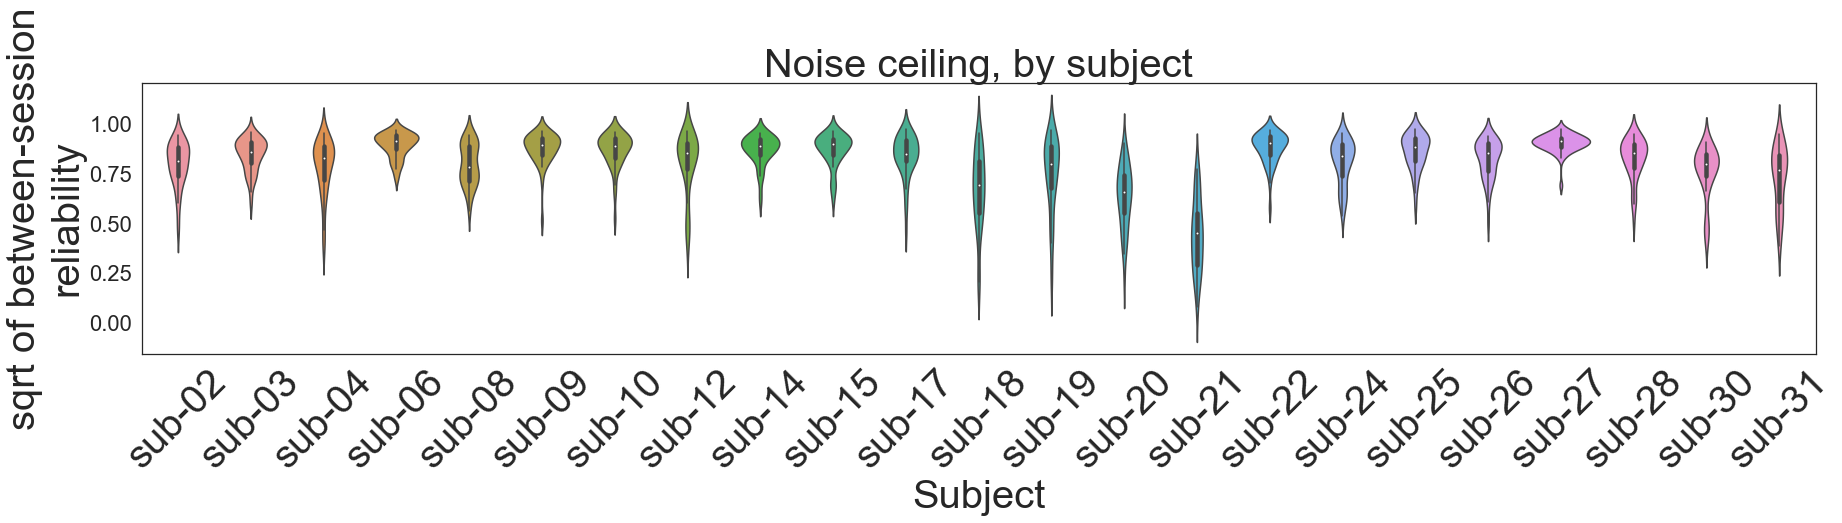

Means by subject:


sub
sub-02    0.799430
sub-03    0.846142
sub-04    0.785401
sub-06    0.893560
sub-08    0.798512
sub-09    0.877572
sub-10    0.868205
sub-12    0.804304
sub-14    0.869829
sub-15    0.870234
sub-17    0.838820
sub-18    0.671423
sub-19    0.747036
sub-20    0.635346
sub-21    0.442917
sub-22    0.880292
sub-24    0.807031
sub-25    0.860954
sub-26    0.823151
sub-27    0.904679
sub-28    0.826940
sub-30    0.759291
sub-31    0.731954
Name: correlation, dtype: float64

In [87]:
# Between-session reliability distributions by subject
plt.figure(figsize=(30, 5))
ax = sns.violinplot(x='sub', y='correlation', data=corrs_all_df[corrs_all_df['type']=='reliability']);
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize=40)
ax.set_ylabel('sqrt of between-session\nreliability', fontsize=40)
ax.set_xlabel('Subject', fontsize=40)
ax.set_title('Noise ceiling, by subject', fontsize=40)
plt.show()
print('Means by subject:')
corrs_all_df[corrs_all_df['type']=='reliability'].groupby('sub').agg('correlation').mean()

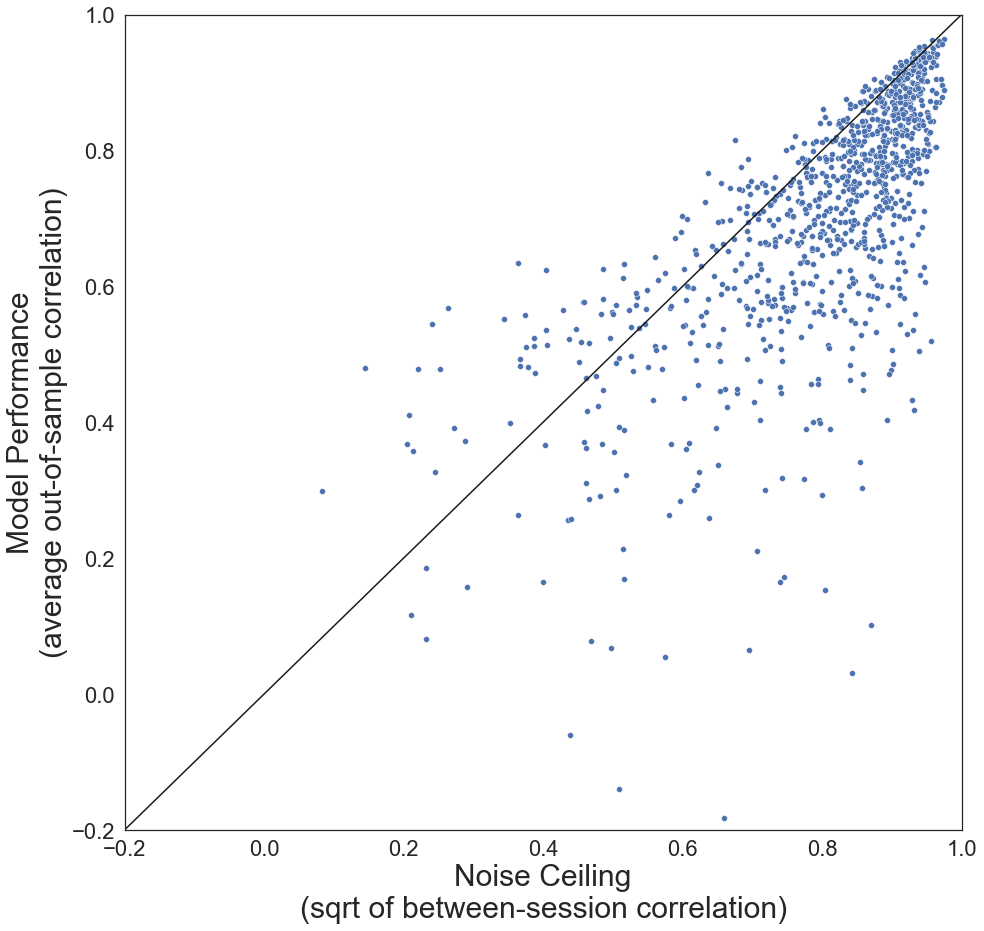

In [88]:
sns.set(style='white', font_scale=2)

plt.figure(figsize=(15,15));
ax = sns.scatterplot(x=corrs_all_df[corrs_all_df['type']=='reliability']['correlation'],
                     y=corrs_all_df[corrs_all_df['type']=='model']['correlation'])
                     #hue=mask)
ax.set_ylabel('Model Performance\n(average out-of-sample correlation)', size=30)
ax.set_xlabel('Noise Ceiling\n(sqrt of between-session correlation)', size=30)
ax.set_ylim(-0.2, 1)
ax.set_xlim(-0.2, 1)

x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, '-k');

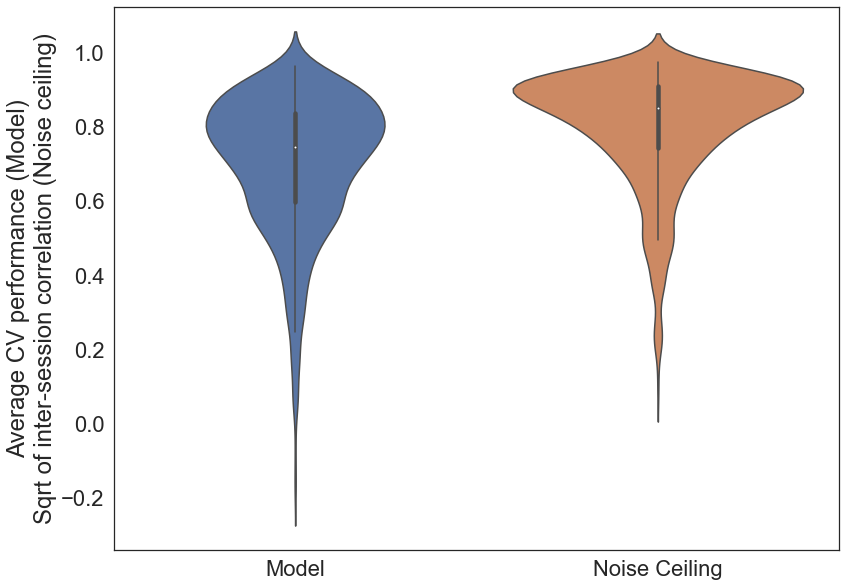

In [89]:
plt.figure(figsize=(13, 10));
ax = sns.violinplot(x='type', y='correlation', data=corrs_all_df);
ax.set_xticklabels(['Model', 'Noise Ceiling'])
ax.set_ylabel('Average CV performance (Model)\nSqrt of inter-session correlation (Noise ceiling)')
ax.set_xlabel('');

/Users/walters/opt/anaconda3/envs/multitask_env/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


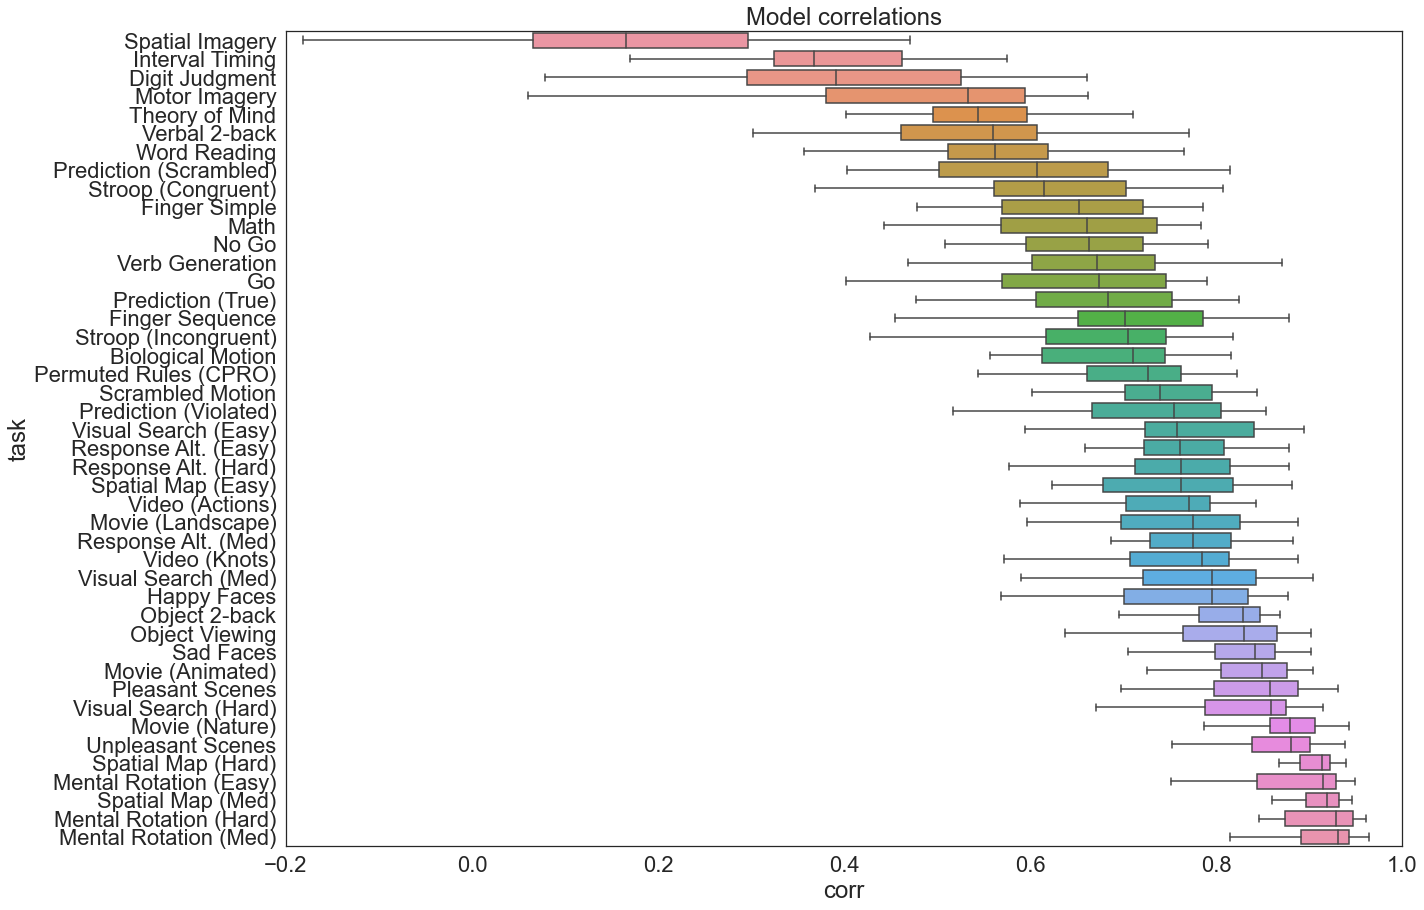

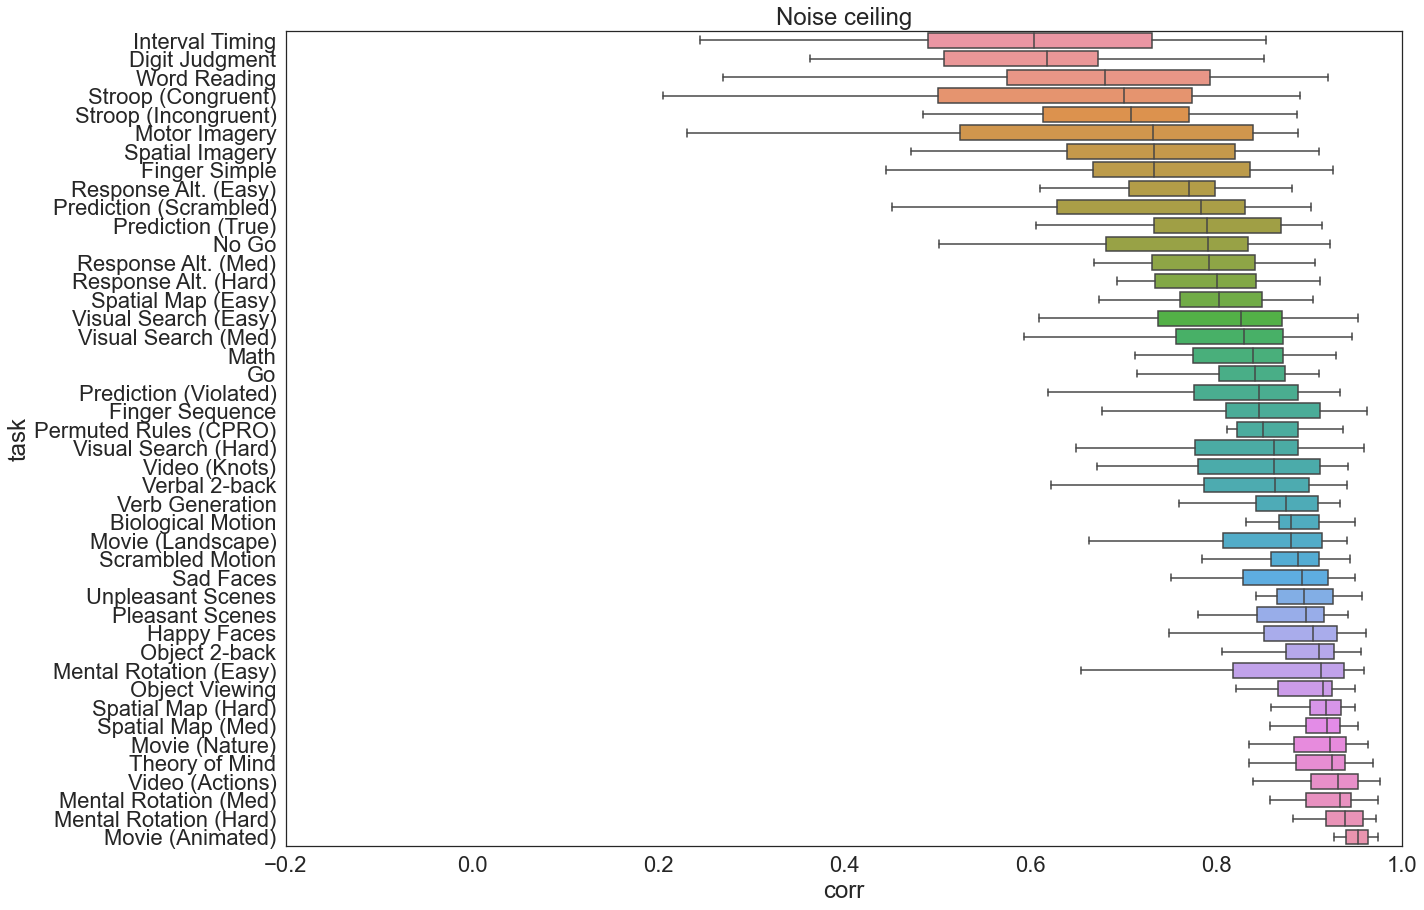

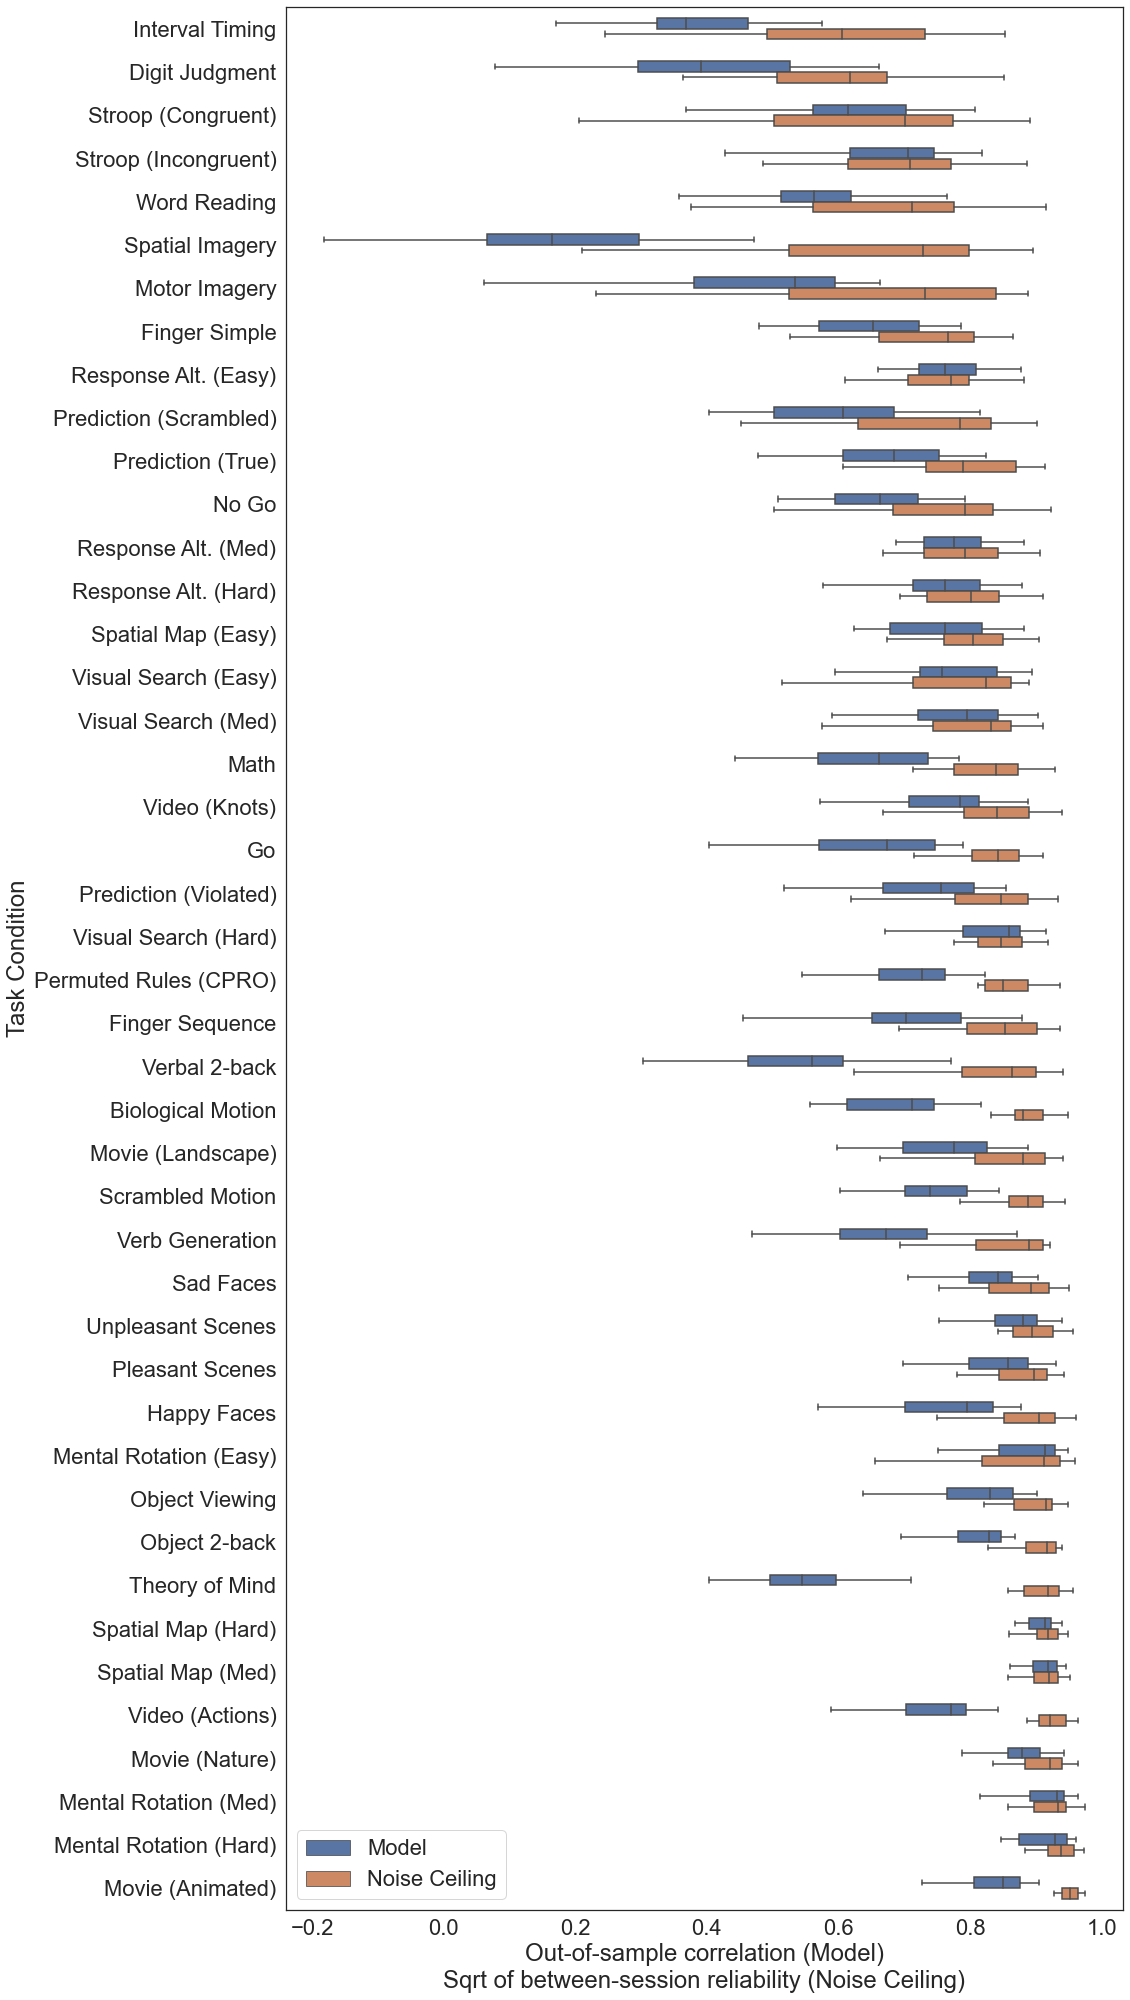

In [90]:
# Plot model corrs
model_corr_df = pd.DataFrame(model_task_corrs)
model_corr_df.columns = task_order
model_corr_df = model_corr_df.melt(var_name='task', value_name='corr')

a = model_corr_df.groupby('task').aggregate('median')
order = a.index.to_numpy()[a.to_numpy().flatten().argsort()]

plt.figure(figsize=(20,15))
sns.boxplot(x='corr', y='task', data=model_corr_df, order=order, showfliers=False)
plt.xlim(-0.2, 1.0)
plt.title('Model correlations')

# Reliabilities
reliability_corr_dict = {i:[] for i in task_order}
for task_idx in range(num_tasks):
    task_name = task_order[task_idx]
    if task2task_inv[task_name] in tasks_a:
        reliability_corr_dict[task_name].extend(reliability_a[task2task_inv[task_name]])
    if task2task_inv[task_name] in tasks_b:
        reliability_corr_dict[task_name].extend(reliability_b[task2task_inv[task_name]])   
        
reliability_corr_df = pd.DataFrame.from_dict(reliability_corr_dict, orient='index').T
reliability_corr_df = reliability_corr_df.melt(value_name='corr', var_name='task').dropna()
reliability_corr_df['corr'] = np.sqrt(reliability_corr_df['corr']).dropna() # square root


# Plot reliabilities
medians = reliability_corr_df.groupby('task').aggregate('median')
order = medians.index.to_numpy()[medians.to_numpy().flatten().argsort()]

plt.figure(figsize=(20,15))
sns.boxplot(x='corr', y='task', data=reliability_corr_df, order=order, showfliers=False);
plt.xlim(-0.2, 1.0);
plt.title('Noise ceiling');


# Plot model correlations and reliabilities side-by-side
medians = corrs_all_df[corrs_all_df['type']=='reliability'].groupby('task').aggregate('median')
order = medians.index.to_numpy()[medians.to_numpy().flatten().argsort()]

plt.figure(figsize=(15,35))
ax = sns.boxplot(x='correlation', y='task', data=corrs_all_df, order=order, hue='type', width=0.5, showfliers=False);
ax.set(ylabel='Task Condition', xlabel='Out-of-sample correlation (Model)\nSqrt of between-session reliability (Noise Ceiling)')
ax.legend(title='');

for t, l in zip(ax.legend_.texts, ['Model', 'Noise Ceiling']):
    t.set_text(l)

## Where is the noise ceiling exceeded?

In [103]:
# Min/max of noise ceiling
print('min noise ceiling:', reliability_corr_df.groupby('task').mean().min()[0])
print('max noise ceiling:', reliability_corr_df.groupby('task').mean().max()[0])

# Percentage of task-subject pairs that exceeded the noise ceiling
m_corrs = corrs_all_df[corrs_all_df['type']=='model']['correlation']
r_corrs = corrs_all_df[corrs_all_df['type']=='reliability']['correlation']
num_corrs = m_corrs.shape[0]
percent_over = (m_corrs > r_corrs).sum() / num_corrs
print('number of task-subject pairs exceeding the noise ceiling:', (m_corrs > r_corrs).sum())
print('percent over:', percent_over)

min noise ceiling: 0.6061384936531027
max noise ceiling: 0.9376638955382202
number of task-subject pairs exceeding the noise ceiling: 176
percent over: 0.17391304347826086


In [106]:
# Examining which subjects and tasks exceeded the noise ceiling

# Get task list
annotation_name = 'X_all.csv'
X_unscaled = pd.read_csv(os.path.join(features_dir, 'byTask', annotation_name), index_col=0)
tasks = X_unscaled.index.tolist()

threshold = 0
exceed_dict = {}
for task in tasks:       
    model_vals = corrs_all_df[(corrs_all_df['task']==task) & (corrs_all_df['type']=='model')]['correlation'].values
    reliability_vals = corrs_all_df[(corrs_all_df['task']==task) & (corrs_all_df['type']=='reliability')]['correlation'].values
    exceed_dict[task] = np.where((model_vals - reliability_vals) > threshold)[0]
    
exceed_list_subs = []
exceed_list_tasks = []
for k, v in exceed_dict.items():
    exceed_list_subs.extend(subs[i] for i in v)
    exceed_list_tasks.extend([k for i in range(len(v))])
    
print(pd.Series(exceed_list_subs).value_counts() / pd.Series(exceed_list_subs).count())
print()
print(pd.Series(exceed_list_tasks).value_counts() / pd.Series(exceed_list_tasks).count())
print()

sub-21    0.113636
sub-20    0.096591
sub-18    0.079545
sub-19    0.073864
sub-12    0.068182
sub-30    0.062500
sub-17    0.056818
sub-31    0.056818
sub-26    0.045455
sub-04    0.039773
sub-28    0.039773
sub-22    0.034091
sub-25    0.034091
sub-15    0.028409
sub-10    0.028409
sub-24    0.028409
sub-08    0.028409
sub-02    0.022727
sub-27    0.017045
sub-09    0.017045
sub-06    0.017045
sub-14    0.011364
dtype: float64

Mental Rotation (Med)     0.079545
Mental Rotation (Easy)    0.079545
Spatial Map (Med)         0.073864
Visual Search (Hard)      0.068182
Response Alt. (Easy)      0.062500
Visual Search (Easy)      0.062500
Visual Search (Med)       0.056818
Stroop (Congruent)        0.051136
Response Alt. (Med)       0.045455
Stroop (Incongruent)      0.045455
Spatial Map (Hard)        0.039773
Mental Rotation (Hard)    0.034091
Response Alt. (Hard)      0.028409
Word Reading              0.022727
Unpleasant Scenes         0.022727
Pleasant Scenes           0.022727
Spatia

In [111]:
# What percentage of subjects and tasks make of most cases of exceeding the noise ceiling?

sub_means = corrs_all_df[corrs_all_df['type']=='reliability'].groupby('sub').agg('correlation').mean().values
sub_means_ordered = np.array(subs)[np.argsort(sub_means)]

proportion_subs = pd.Series(exceed_list_subs).value_counts() / pd.Series(exceed_list_subs).count()
proportion_tasks = pd.Series(exceed_list_tasks).value_counts() / pd.Series(exceed_list_tasks).count()

check_tasks = ['Mental Rotation', 'Spatial Map', 'Visual Search', 'Response Alt.', 'Prediction']
percents = []
for i in proportion_tasks.index:
    for t in check_tasks:
        if t in i:
            percents.append(proportion_tasks[i])
print('top 5 tasks:', np.sum(percents))

check_subs = sub_means_ordered[0:5]
percents = []
for i in proportion_subs.index:
    for s in check_subs:
        if s in i:
            percents.append(proportion_subs[i])
print('top 5 subs:', np.sum(percents))

top 5 tasks: 0.6988636363636365
top 5 subs: 0.4204545454545454


# Confusion matrix and RDMs

## Preliminaries

In [29]:
## Load X
annotation_name = 'X_all.csv'
X_unscaled = pd.read_csv(os.path.join(features_dir, 'byTask', annotation_name), index_col=0)
task_order = X_unscaled.index.tolist()
features = X_unscaled.columns.tolist()

# clipped (for visualization)
X_unscaled_clipped = X_unscaled.where(X_unscaled <= 1, 1)

# feature-wise norm
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_unscaled)

# tasks and cognitive functions
tasks = X_unscaled.index.tolist()
functions = X_unscaled.columns.tolist()


## Load csv file that labels each cogatlas entity as 'cognitive' or 'perceptual-motor'
labels_dir = os.path.join(features_dir, 'cognitive_perceptual-motor_labels.csv')
labels_df = pd.read_csv(labels_dir)
cognitive_features = labels_df[labels_df['Cognitive'] == 1]['Entity'].tolist()
perceptual_motor_features = labels_df[labels_df['Perceptual-motor'] == 1]['Entity'].tolist()

functions_labeled = []
for function in functions:
    if function in cognitive_features:
        name = function + ' (C)'
    elif function in perceptual_motor_features:
        name = function + ' (P)'
    else:
        print(function + ' not in either class')
    functions_labeled.append(name)

In [53]:
def cluster_plot(df, title, labels, similarity_metric, method, vmin=None, vmax=None):
    rdm_condensed = sp.spatial.distance.pdist(df.T, metric=similarity_metric)
    rdm = sp.spatial.distance.squareform(rdm_condensed)
    linkage = hc.linkage(rdm_condensed, method='average', optimal_ordering=True)
    ax = sns.clustermap(rdm, row_linkage=linkage, col_linkage=linkage,
                        yticklabels=labels,
                        xticklabels=labels,
                        figsize=(13,13),
                        vmin=vmin, vmax=vmax,
                        linewidths=0.05, linecolor='gray')
    x0, _y0, _w, _h = ax.cbar_pos
    ax.ax_cbar.set_position([x0, 0.9, ax.ax_row_dendrogram.get_position().width, 0.02])
    ax.fig.suptitle(title, y=1.05)
    return(ax, rdm)
    
    
def calc_confusion_mat(res, task_order):
    num_tasks = len(task_order)
    subs = res['sub'].values.tolist()
    num_subs = len(subs)
    
    ## Calculate confusion matrix [actual, predicted]
    confusion_mtx = np.zeros([num_tasks, num_tasks])
    for sub in subs:
        # acc2_vals[i] = tuple (acc_0, acc_1)
        # where acc_0=1 if held-out image 0 was correctly classified (else, acc_0=0)
        acc2_vals = res[res['sub']==sub]['acc2_vals'].to_list()[0][0]
        testpairs = res[res['sub']==sub]['testpairs'].to_list()[0][0]
        testpairs = [(min(pair), max(pair)) for pair in testpairs]
        for a, p in zip(acc2_vals, testpairs):
            if a[0] == 1: # prediction 0 was correctly classified as held out 0
                confusion_mtx[p[0],p[0]] += 1
            if a[1] == 1: # prediction 1 was correctly classified as held out 1
                confusion_mtx[p[1],p[1]] += 1
            if a[0] == 0: # prediction 0 was incorrectly classified as held out 1 (when it was 0, thought it was 1)
                confusion_mtx[p[0],p[1]] += 1
            if a[1] == 0: # prediction 1 was incorrectly classified as held out 0 (when it was 1, thought it was 0)
                confusion_mtx[p[1],p[0]] += 1
                
    ## Convert counts to proportions:
    # Each off-digaonal comparison occurred once per subject (ie, 23 instances)
    confusion_mtx /= num_subs

    # Each diagonal comparison appeared num_tasks-1 times per subject (ie, 43*23 instances)
    confusion_mtx[np.diag_indices_from(confusion_mtx)] /= (num_tasks-1)

    return confusion_mtx


def plot_concepts(Xproj, concepts_names):
    x = Xproj[:,0]
    y = Xproj[:,1]
    fig, ax = plt.subplots(figsize=(15,15))
    ax.scatter(x, y)
    for i, txt in enumerate(concepts_names):
        ax.annotate(txt, (x[i],y[i]), fontsize=20)
        

def plot_confusions_rdms(res, X, concept_order, task_order, title_label, 
                         mds=False, similarity_metric='cosine', method='ward'):
    sns.set(font_scale=1)
    filetype = 'pdf'
    
    # Calculate confusion matrix
    confusion_mat = calc_confusion_mat(res, task_order)

    # Plot confusion matrix
    plt.figure(figsize=(13,11))
    ax = sns.heatmap(confusion_mat, yticklabels=task_order, xticklabels=task_order,
                     linewidths=0.05, linecolor='gray')
    ax.set(title='', ylabel='True', xlabel='Predicted');
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, 'confusion-matrix_model.%s' % filetype))

    # Plot task similarity based on model performance
    title = 'Task similarity based on encoding model performance (%s)' % title_label
    ax, rdm_taskSim_classifier = cluster_plot(confusion_mat, title, task_order,
                                              similarity_metric=similarity_metric,
                                              method=method)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, 'task-similarity_model.%s' % filetype))
    
    
    # Plot task similarity based on annoations
    title = 'Task similarity based on annotations'
    ax, rdm_taskSim_features = cluster_plot(X.T, title, task_order,
                                            similarity_metric=similarity_metric,
                                            method=method)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, 'task-similarity_features.%s' % filetype))

    
    ## Projection of confusion matrix into cognitive space
    
    # Plot concept similarity based on model
    vmin = None
    vmax = None
    title = 'Concept similarity based on encoding model performance (%s)' % title_label
    proj = np.matmul(confusion_mat, X)
    ax, rdm_conceptSim_classifier = cluster_plot(proj, title, concept_order,
                                                 similarity_metric=similarity_metric,
                                                 method=method,
                                                 vmin=vmin, vmax=vmax)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, 'concept-similarity_model.%s' % filetype))
    

    # Plot concept similarity based on annotations
    vmin = None
    vmax = None
    title = 'Concept similarity based on annotations'
    ax, rdm_conceptSim_features = cluster_plot(X, title, concept_order,
                                               similarity_metric=similarity_metric,
                                               method=method,
                                               vmin=vmin, vmax=vmax)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, 'concept-similarity_features.%s' % filetype))
    
    
    ## Multidimensional scaling (MDS) of concept RDM
    if mds:
        mds = manifold.MDS(2, random_state=0, dissimilarity='precomputed', max_iter=3000)
        summary = mds.fit_transform(concept_rdm)
        plot_concepts(summary, concept_order)
    
    return (confusion_mat)

## Plots

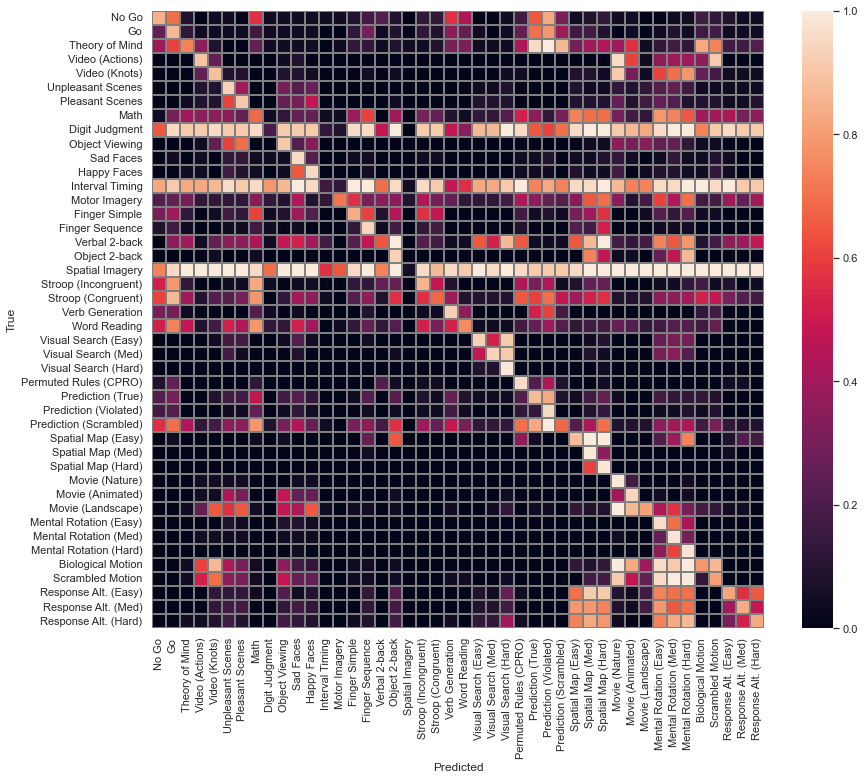

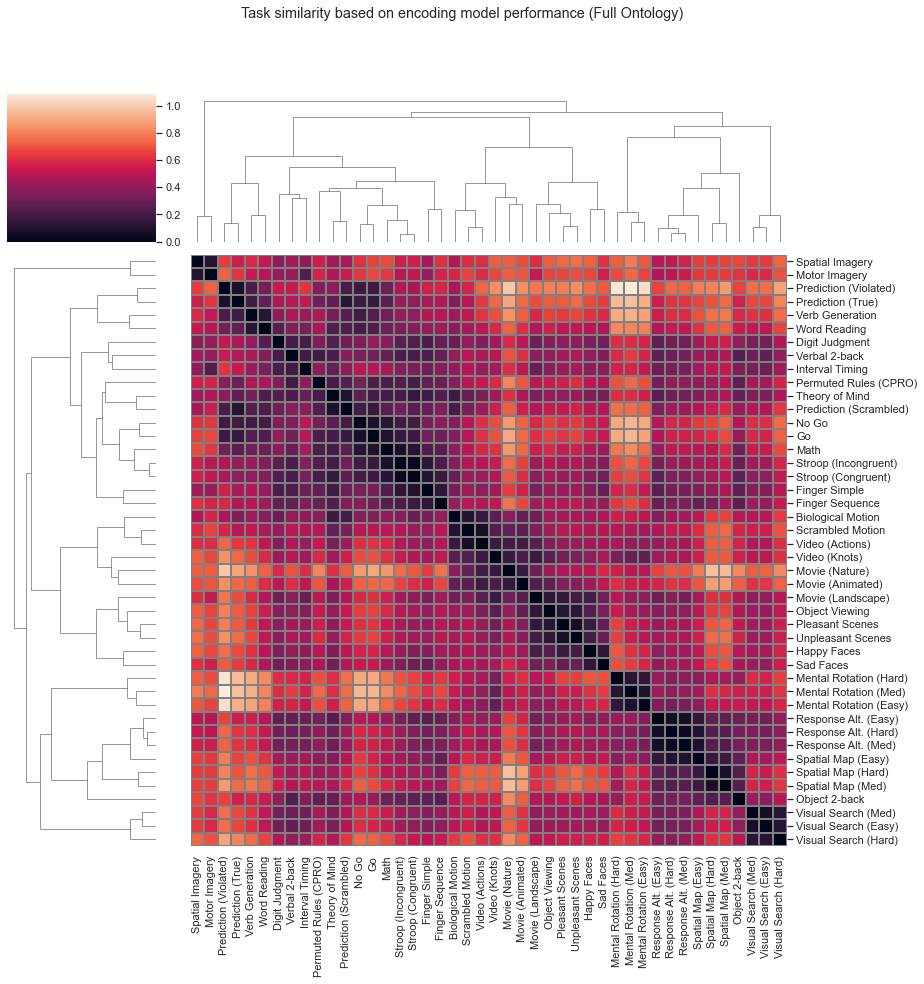

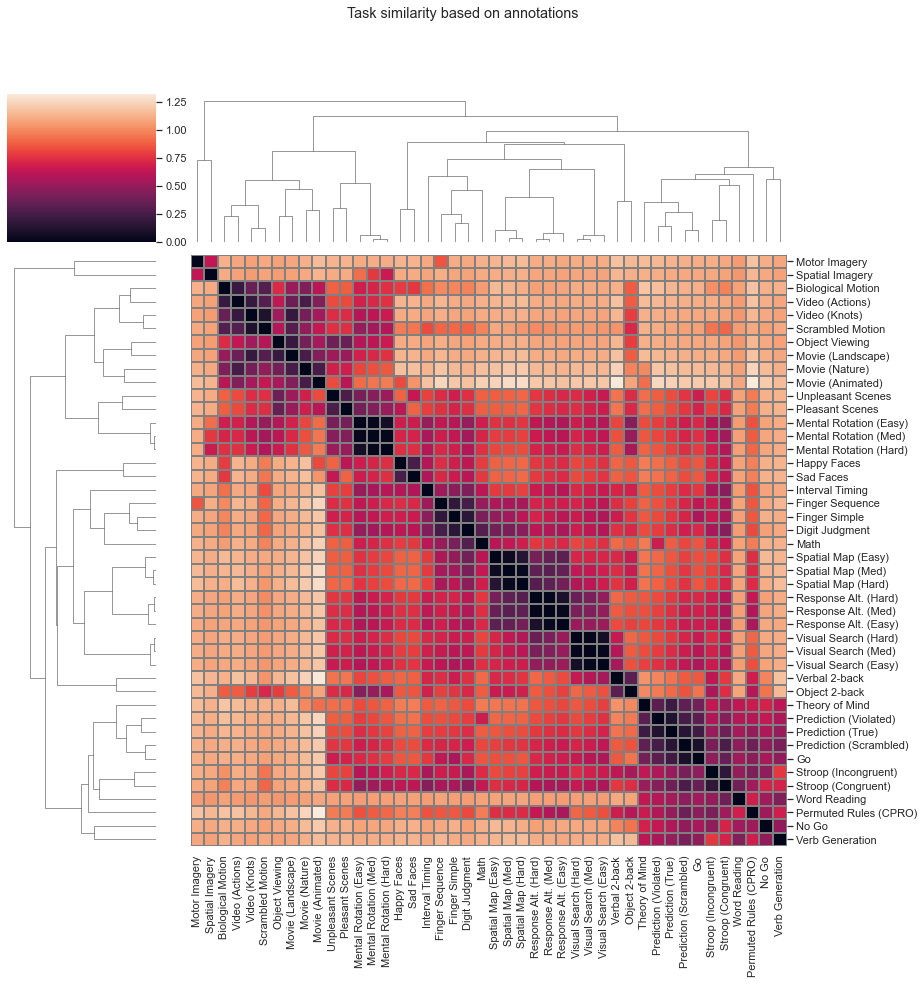

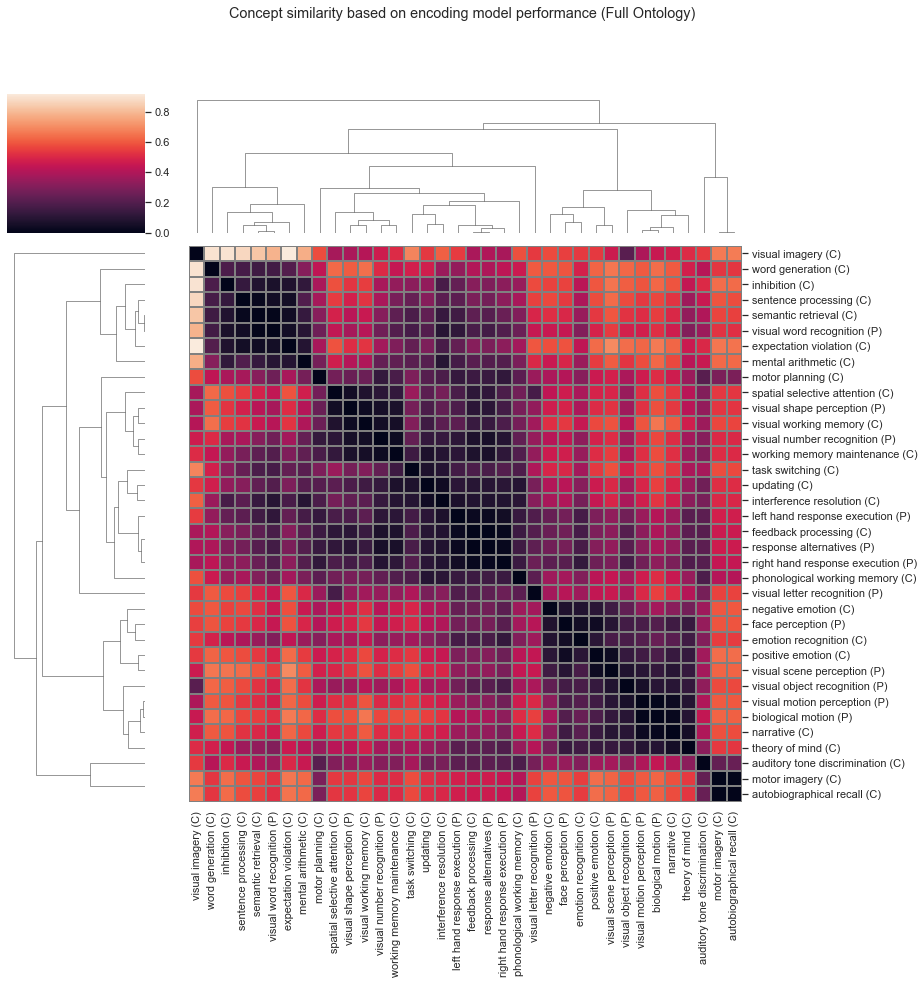

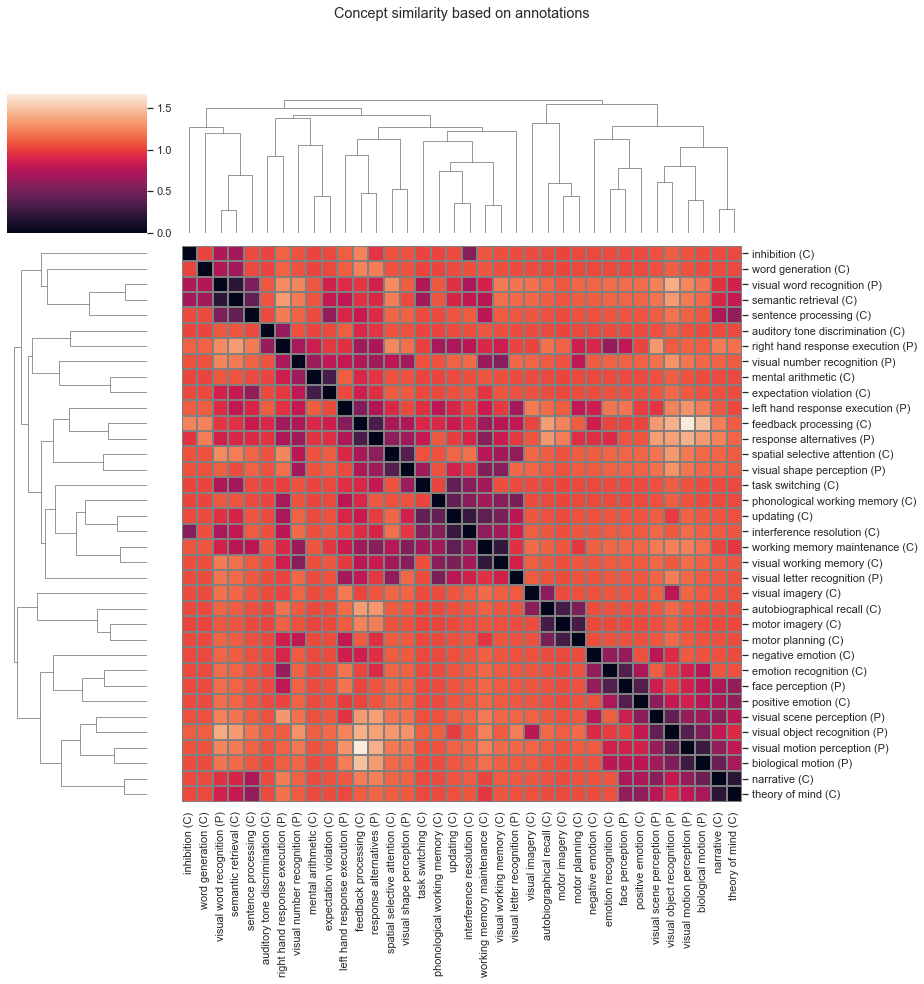

In [72]:
feature_set = 'all'
title_label = 'Full Ontology'
similarity_metric = 'correlation'
method = 'average'
df = res_df

res = df[df['feature_set'] == feature_set]

confusion_mat = plot_confusions_rdms(res, X_scaled, functions_labeled, task_order, 
                                     title_label=title_label,
                                     similarity_metric=similarity_metric,
                                     method=method)